In [9]:
path  = 'Bank Customer Churn Prediction.csv'

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import mplcyberpunk
from qbstyles import mpl_style
#plt.style.use('cyberpunk')
mpl_style(dark = True)
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skew
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,recall_score, accuracy_score, roc_auc_score,f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
import catboost as cb
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv(path).iloc[:,1:]
df

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [37]:
df['is_overbalanced'] = (df.estimated_salary - df.balance).apply(lambda x: 0 if x >= 0 else 1)
df

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,is_overbalanced
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1,0
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   products_number   10000 non-null  int64  
 7   credit_card       10000 non-null  int64  
 8   active_member     10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  churn             10000 non-null  int64  
 11  is_overbalanced   10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


### Split the categorical and numerical columns

I create a for loop to find the columns with more than 5 unique values. This is my threshold for a column to be be considered categorical or numerical. 
After splitting the columns, I start generating histogram, boxplot and qqplot for each numerical column to check the data distributions. Also, I find the skewness level for each continuous data piece. If a column has more than absolute 0.5, I use logarithmic transformation to have the data approximated to normal distribution. 


As for the categorical data, I check the number of data points comes from each column category by creating countplots.

In [39]:
def split_cats_nums(dataset):
    categoricals = []
    numericals = []
    for i in dataset.columns:
        if len(dataset[i].unique()) > 5:
            numericals.append(i)
        else:
            categoricals.append(i)
    categoricals = [t for t in categoricals if t!="churn"]
    return categoricals, numericals
categoricals,numericals = split_cats_nums(df)


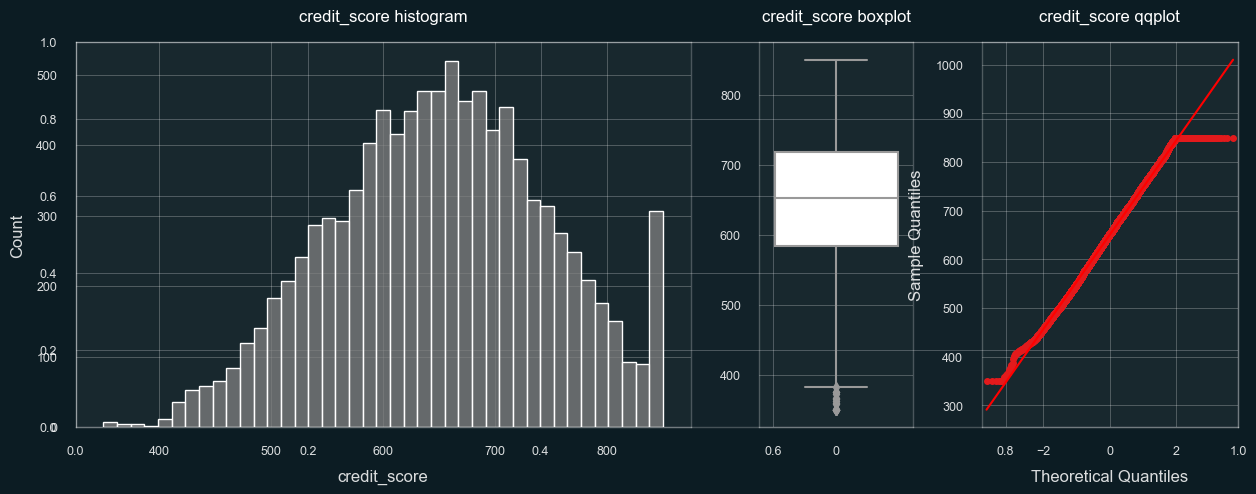

The skewness value for the credit_score is -0.07159586676212397


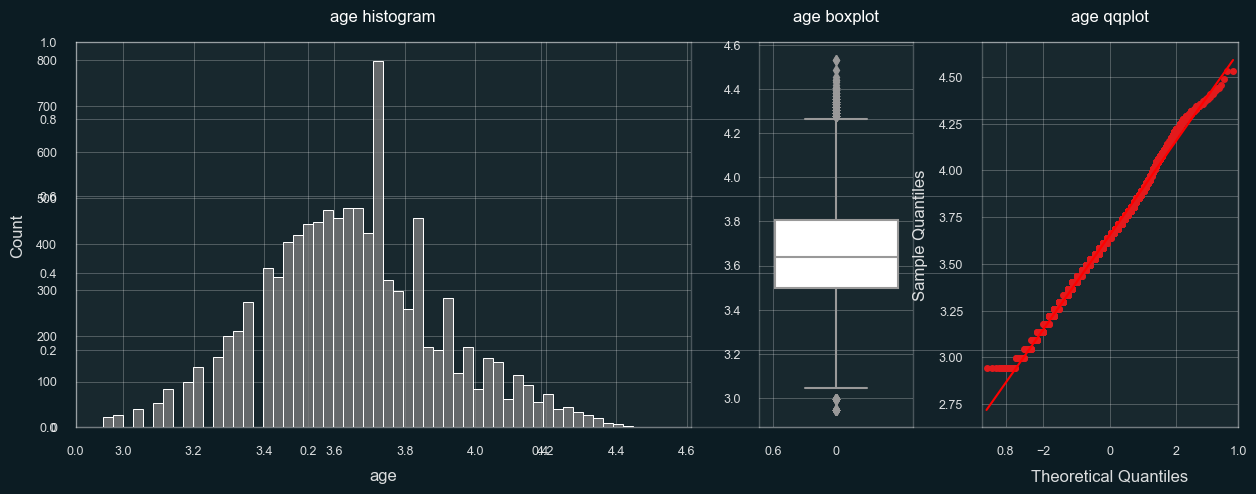

The skewness value for the age is 0.20332990983646618


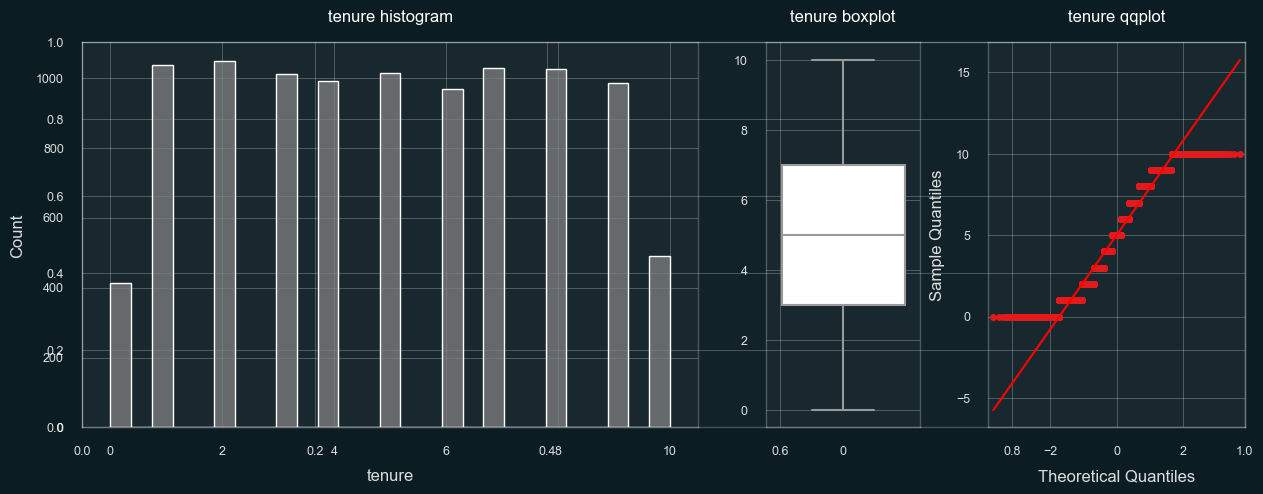

The skewness value for the tenure is 0.010989809189781041


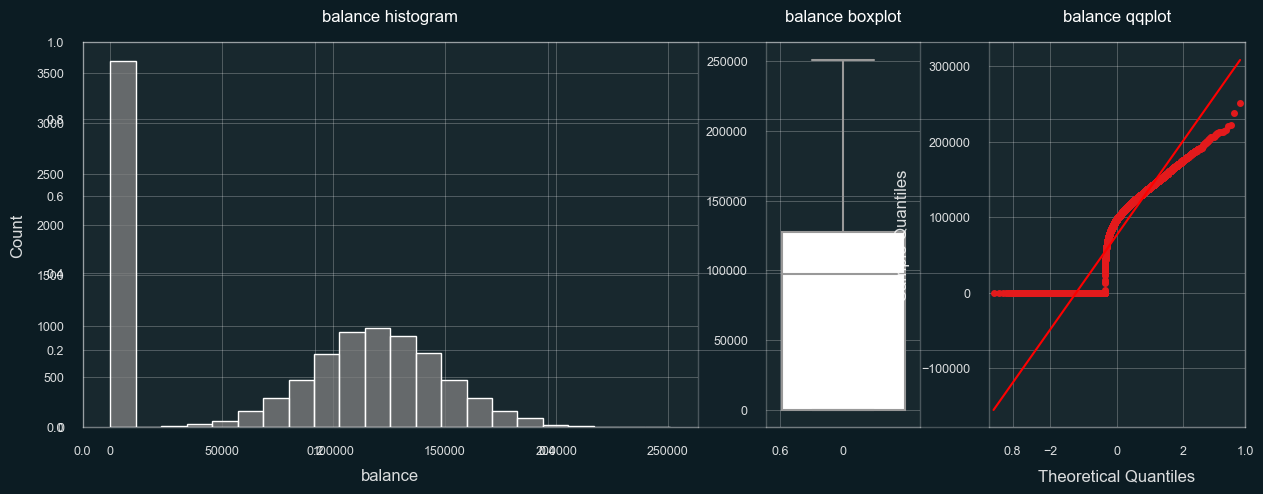

The skewness value for the balance is -0.14108754375291138


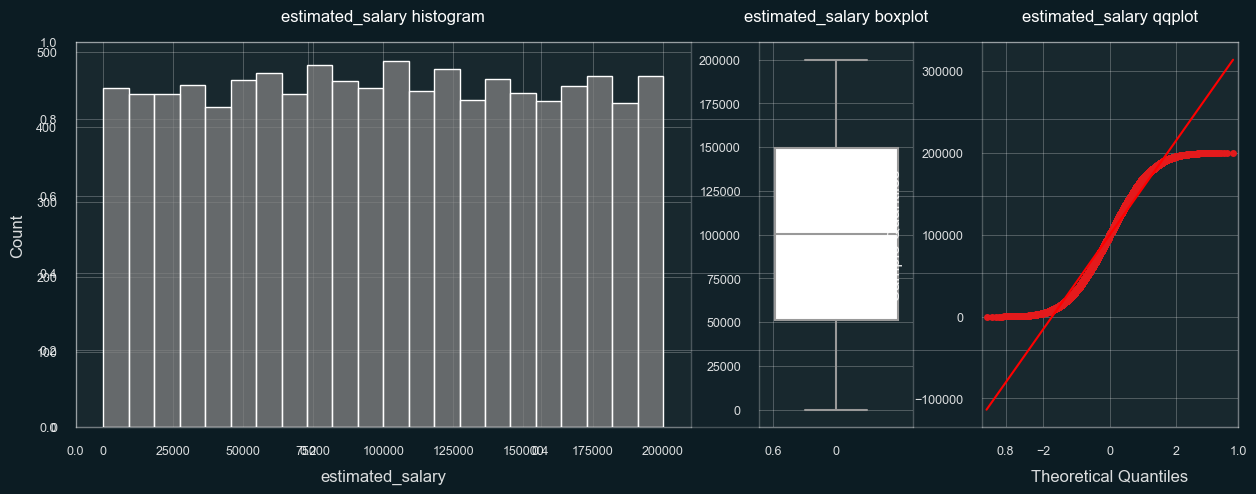

The skewness value for the estimated_salary is 0.0020850448448748848


In [52]:

def generate_numerical_viz(data):
    for i in data[numericals]:
        fig, axes = plt.subplots(1,3,figsize = (15,5),gridspec_kw={'width_ratios': [2.4, 0.6,1]})
        sns.histplot(data[i],ax=axes[0],color = 'gray')
        axes[0].set_title(f"{i} histogram")
        sns.boxplot(data[i],ax=axes[1],palette=["white",'yellow'])
        axes[1].set_title(f"{i} boxplot")
        qqplot(data[i],ax = axes[2],line="s",)    
        axes[2].set_title(f"{i} qqplot")
        plt.show()
        print(f"The skewness value for the {i} is {skew(data[i])}")
generate_numerical_viz(df)

In [41]:
df['age'] = np.log1p(df.age)

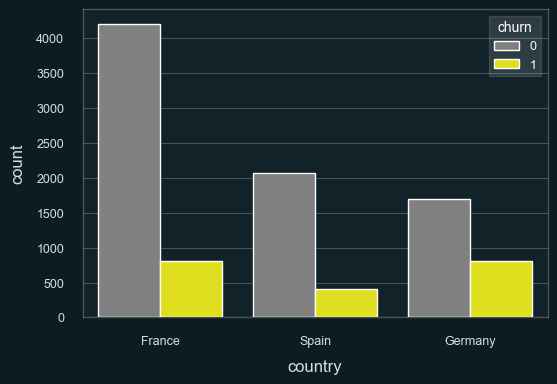

16.15% of customers from France has churned. 
16.67% of customers from Spain has churned. 
32.44% of customers from Germany has churned. 


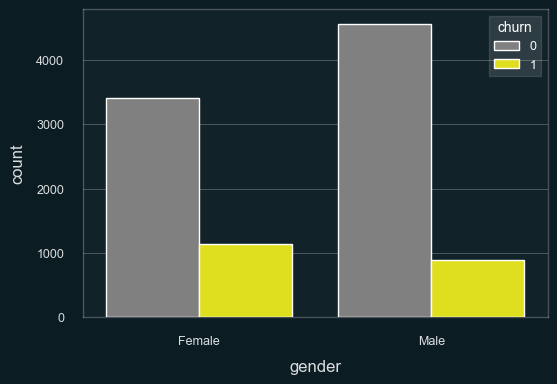

25.07% of customers who are Female has churned. 
16.46% of customers who are Male has churned. 


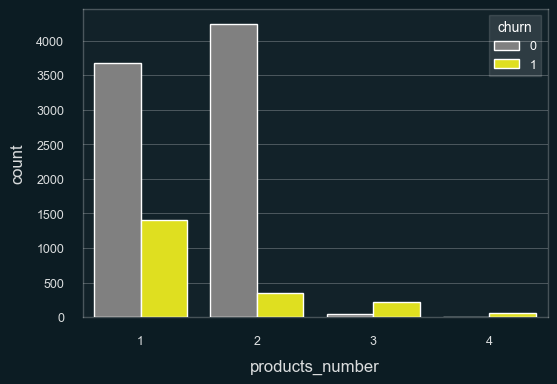

27.71% of customers who use 1 products_number has churned. 
82.71% of customers who use 3 products_number has churned. 
7.58% of customers who use 2 products_number has churned. 
100.0% of customers who use 4 products_number has churned. 


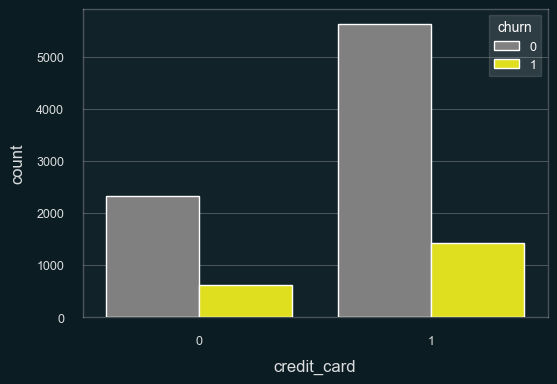

20.18% of customers who use 1 credit_card has churned. 
20.81% of customers who use 0 credit_card has churned. 


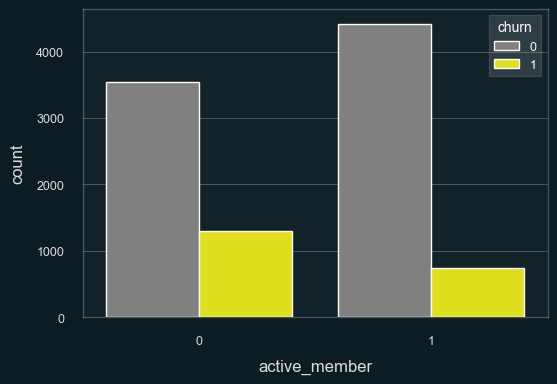

14.27% of customers who are 1 has churned. 
26.85% of customers who are 0 has churned. 


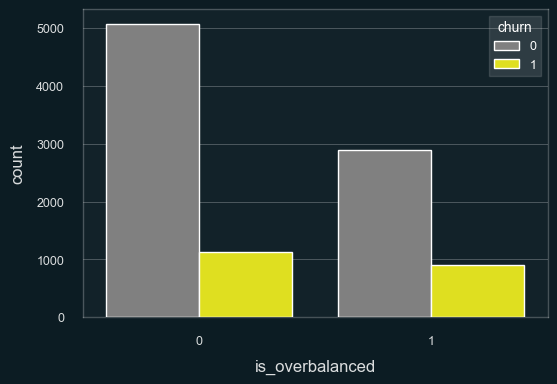

18.26% of customers who are 0 has churned. 
23.83% of customers who are 1 has churned. 


In [46]:
def generate_cat_viz(data):
    for i in categoricals :
        plt.figure(figsize=(6,4))
        sns.countplot(data = data, x = i ,hue = "churn",palette = ['gray', 'yellow'])
        plt.show()
        for x in data[i].unique():
            churn_pcnt = len(data[(data[i] == x) & (data["churn"] == 1)]) / len(data[data[i]==x]) *100
            churn_pcnt = round(churn_pcnt,2)
            if i =="country":
                print(f"{churn_pcnt}% of customers from {x} has churned. ")
            elif i not in(["credit_card","products_number"]):
                print(f"{churn_pcnt}% of customers who are {x} has churned. ")
            else:
                print(f"{churn_pcnt}% of customers who use {x} {i} has churned. ")
generate_cat_viz(df)

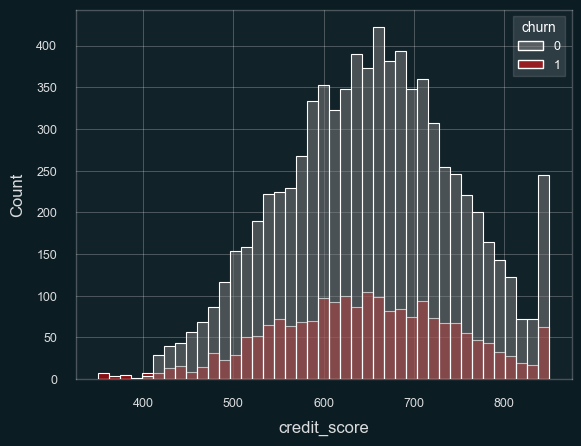

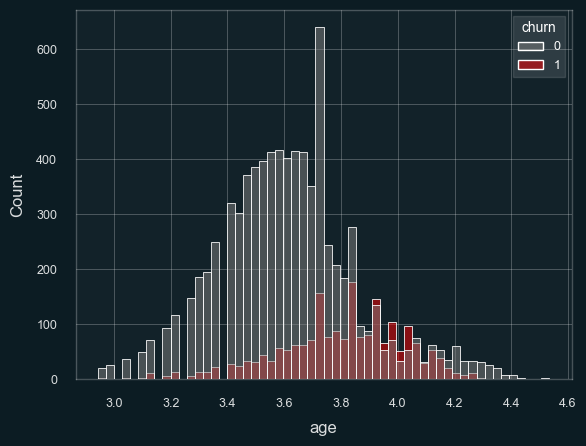

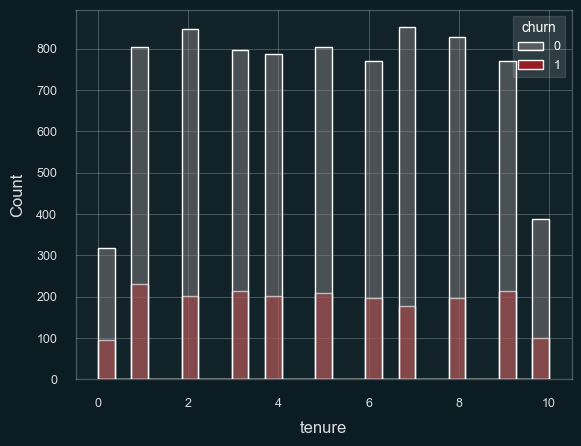

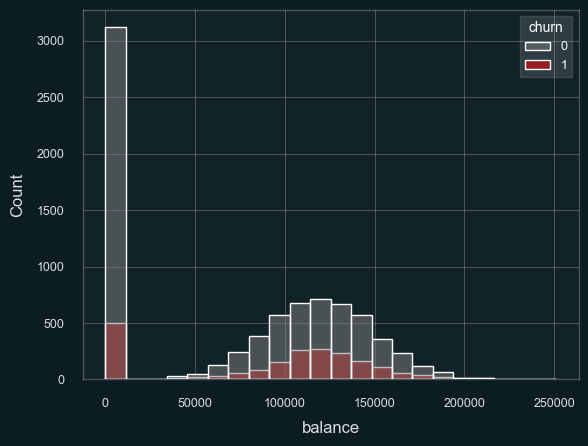

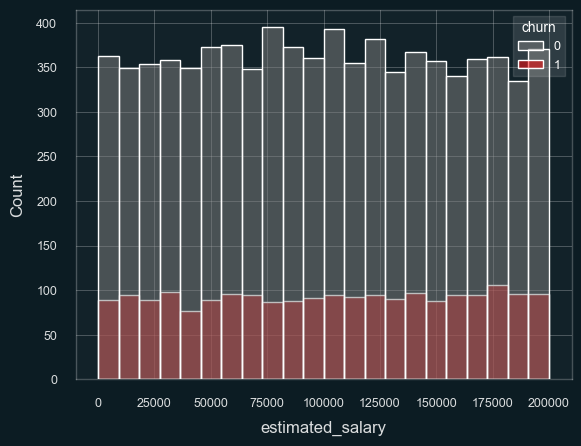

In [45]:
for t in numericals:
    sns.histplot(data = df ,x = t, hue = "churn",alpha = 0.5, palette= ['gray','red'])
    plt.show()

I found that the customers who has credit score lower than 400 are guaranteed to churn. Therefore, I created a binary column indicating whether the customer has lower than 400 credit score. I hope this feature will increase the success rate of my model in predictions.

In [18]:
df["is_low"] = df.credit_score.apply(lambda x : 1 if x < 400 else 0)
categoricals.append("is_low")

scaler = RobustScaler()
df[numericals] = scaler.fit_transform(df[numericals])
df

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,is_overbalanced,is_low
0,-0.246269,France,Female,0.398556,-0.75,-0.761480,1,1,1,0.011739,1,0,0
1,-0.328358,Spain,Female,0.322689,-1.00,-0.104906,1,0,1,0.125512,0,0,0
2,-1.119403,France,Female,0.398556,0.75,0.489346,3,1,0,0.139630,1,1,0
3,0.350746,France,Female,0.165380,-1.00,-0.761480,2,0,0,-0.064717,0,0,0
4,1.477612,Spain,Female,0.472678,-0.75,0.221806,1,1,1,-0.214561,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.888060,France,Male,0.165380,0.00,-0.761480,2,1,0,-0.039876,0,0,0
9996,-1.014925,France,Male,-0.174323,1.25,-0.312031,1,1,1,0.015306,0,0,0
9997,0.425373,France,Female,-0.085984,0.50,-0.761480,1,0,1,-0.590615,1,0,0
9998,0.895522,Germany,Male,0.398556,-0.50,-0.173319,2,1,0,-0.074252,1,0,0


## Feature Selection


I use chi squared test to calculate the impact level for each column on the target column. The ones that show relatively low impact are dropped from the data to reduce the noise.   

In [19]:
enc = LabelEncoder()
for c in categoricals:
    df[c] = enc.fit_transform(df[c])

features = df.loc[:,categoricals]
target = df.loc[:,'churn']

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

In [20]:
featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']).sort_values(ascending = False,by = ["Chi Squared Score"])
featureScores

,Chi Squared Score
active_member,118.199414
is_low,74.274423
gender,51.539926
is_overbalanced,27.954538
products_number,14.590276
country,11.853251
credit_card,0.150041


We will drop the "credit_card" column since it does not have much impact on churn.

In [21]:
df.drop(columns = ["credit_card"],inplace = True)

## Other feature engineering methods I tried:
PCA: After repetitive trials, I could not find a better model trained using the data truncated with principal component analysis. 

Binning : I tried to create bins out of the age data considering that some age groups act similarly. I tried 6,8 and 12 bins but there was not improvement in the model. 

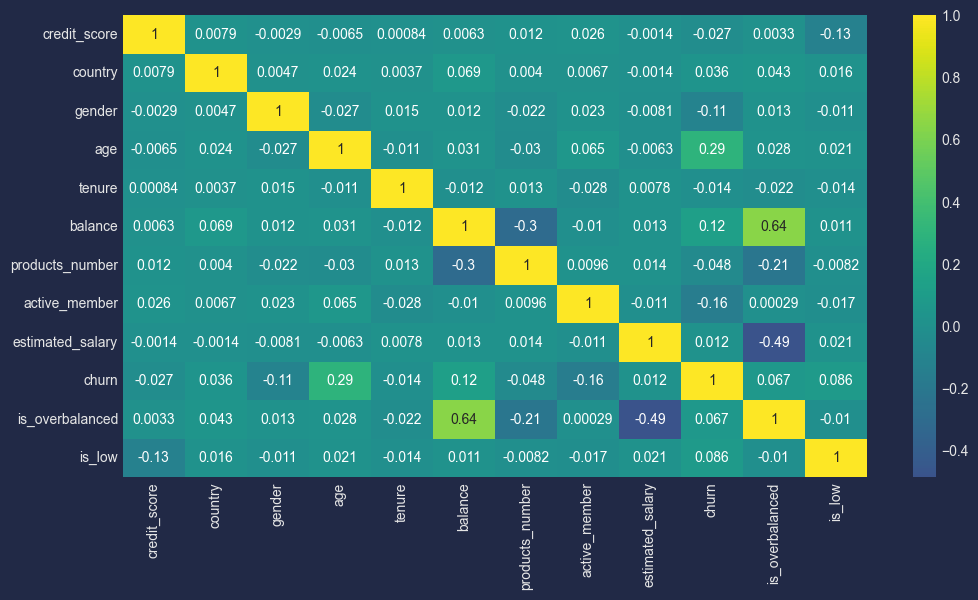

In [35]:
cor = df.corr()
plt.figure(figsize= (12,6))
sns.heatmap(cor, annot = True, fmt=".2g",cmap= 'viridis', center = 0)
plt.show()

## VIF Analysis

After chi2 test, I also ran a VIF test to check the multicollinearity. All variables show VIF value lower than 5, meaning that columns do not include serious multicollinearity.

In [23]:
# Add a constant column to the DataFrame
pp = sm.add_constant(df)
# Calculate VIF for each variable
vif = pd.DataFrame()
vif['Variable'] = pp.columns
vif['VIF'] = [variance_inflation_factor(pp.values, i) for i in range(pp.shape[1])]
vif


,Variable,VIF
0,const,8.522413
1,credit_score,1.017767
2,country,1.007056
3,gender,1.012929
4,age,1.111131
5,tenure,1.002184
6,balance,2.336589
7,products_number,1.104665
8,active_member,1.041236
9,estimated_salary,1.709659


## Oversampling with replication

The data is imbalanced, meaning that the one or more classes of target column dominates the dataset in terms of count. This might create a problem since the model do not have enough chance to see each occurrence. In this case, the data includes 2037 churner and 7963 non-churner customers.

In [24]:
def oversamp(df):
    churners = df[df['churn'] == 1]
    non_churners = df[df['churn'] == 0]
    print(len(churners))
    print(len(non_churners))
    oversampled = churners.sample(len(non_churners),replace = True)
    df = pd.concat([non_churners,oversampled])
    return df

#df = oversamp(df)

### Smote Oversampling

In [25]:
def Smote_oversample(data):
    X = data.drop(columns= ['churn'])
    y = data['churn']

    smote = SMOTE(sampling_strategy='minority')
    X , y = smote.fit_resample(X,y)
    return X,y

X,y = Smote_oversample(df)

## Splitting the data into train and test

In [26]:
fold = KFold(n_splits = 5, shuffle = True, random_state = 3)
x_train, x_test, y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 2)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((12740, 11), (12740,), (3186, 11), (3186,))

## BASIC MODELLING

### Cross validation 

In [27]:
mods = [XGBClassifier(),CatBoostClassifier(verbose= False),LGBMClassifier(verbose= -1)]
def get_cv_Scores(models):
    scores = {}
    for model in models:
        cvscore = cross_val_score(model,X,y,cv = fold,verbose = 0)
        scores[str(model)[:10]] = np.mean(cvscore)
        scores = pd.DataFrame(data=scores,index= ["Accuracy CV"])
    return scores
cv_sc =  get_cv_Scores(mods)
cv_sc

,XGBClassif,<catboost.,LGBMClassi
Accuracy CV,0.903868,0.907007,0.903617


### Predictions

In [29]:
def get_scores(models):
    prediction_results = {}
    for model in models:
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        recall = recall_score(y_pred,y_test)
        precision = precision_score(y_pred,y_test)
        accuracy = accuracy_score(y_pred,y_test)
        roc = roc_auc_score(y_pred,y_test)
        f1 = f1_score(y_pred,y_test)
        prediction_results[str(model)[:10]] = [accuracy,precision,recall,roc,f1]
    results_df = pd.DataFrame(data = prediction_results, index = ["Accuracy", "Precision", "Recall","ROC-AUC","F1"])
    return results_df

predictions = get_scores(mods)
results_f = pd.concat([cv_sc,predictions])
results_f.style.highlight_max(axis=1,color = 'green')


,XGBClassif,<catboost.,LGBMClassi
Accuracy CV,0.903868,0.907007,0.903617
Accuracy,0.903955,0.910232,0.907094
Precision,0.870581,0.877525,0.877525
Recall,0.931757,0.937922,0.931635
ROC-AUC,0.905796,0.912036,0.908557
F1,0.900131,0.906719,0.903771


## Stacked Model

I stack models to get benefit from each. Sometimes a model can fall short of detecting patterns. We get the average of predictions made in each iterations to reach more robust predictions.

In [30]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.base import clone
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)
            
        return self
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        predictions = np.mean(predictions, axis=1)
        return np.where(predictions > 0.5,1,0)

## Comparison of the models

In [32]:
stacked = AveragingModels(models = mods)
stacked.fit(x_train,y_train)
pred_st = stacked.predict(x_test)
recall_st = recall_score(pred_st,y_test)
precision_st = precision_score(pred_st,y_test)
accuracy_st = accuracy_score(pred_st,y_test)
roc_st = roc_auc_score(pred_st,y_test)
f1_st = f1_score(pred_st,y_test)
results_f["Stacked"] = [0,accuracy_st,precision_st,recall_st,roc_st,f1_st]
results_f.rename(columns = {"<catboost.":"CB"},inplace=True)
results_f.style.highlight_max(axis=1,color = 'green')

,XGBClassif,CB,LGBMClassi,Stacked
Accuracy CV,0.903868,0.907007,0.903617,0.000000
Accuracy,0.903955,0.910232,0.907094,0.911174
Precision,0.870581,0.877525,0.877525,0.881944
Recall,0.931757,0.937922,0.931635,0.935700
ROC-AUC,0.905796,0.912036,0.908557,0.912623
F1,0.900131,0.906719,0.903771,0.908027


Eventhough it is a small margin, the stacked model outperformed all of its components. For a bank, a small margin in the success rate might mean millions of dollars more revenue. 

## Interactive Visualization

I created a dashboard covering the relationship between the target and feature variables. The dashboard shows aggregated values for several features. Please click on the charts to apply filters on the data.

In [33]:
%%HTML
<div class='tableauPlaceholder' id='viz1687866380794' style='position: relative'><noscript><a href='#'><img alt='Churn Analysis for Bank Seguro ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ch&#47;ChurnEDA_16876850312390&#47;OverviewforKaggle&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='ChurnEDA_16876850312390&#47;OverviewforKaggle' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ch&#47;ChurnEDA_16876850312390&#47;OverviewforKaggle&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-GB' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1687866380794');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='1080px';vizElement.style.minHeight='787px';vizElement.style.maxHeight='987px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='1080px';vizElement.style.minHeight='787px';vizElement.style.maxHeight='987px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else { vizElement.style.width='100%';vizElement.style.height='2527px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

## Evaluation of the model



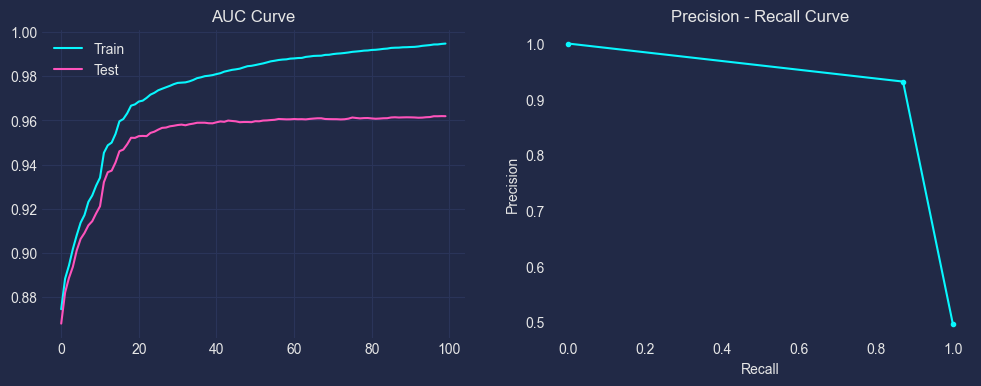

In [34]:
# Create the evaluation data as a single tuple or list
evals = [(x_train, y_train), (x_test, y_test)]

# Define the evaluation metrics
eval_metrics = ['auc', 'error']

# Create the XGBoost model
model1 = XGBClassifier()

# Train the XGBoost model
model1.fit(x_train, y_train, eval_set=evals, eval_metric=eval_metrics, verbose=False)
xgb_pred = model1.predict(x_test)
precision, recall, thresholds = precision_recall_curve(y_test, xgb_pred)
# Get the evaluation results
results = model1.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# Plot the AUC values
fig, ax = plt.subplots(1,2, figsize = (12,4))
ax[0].plot(x_axis, results['validation_0']['auc'], label='Train')
ax[0].plot(x_axis, results['validation_1']['auc'], label='Test')
ax[0].legend()
ax[0].set_title("AUC Curve") 
# Plot the recall curve
ax[1].plot(recall, precision, marker='.')
ax[1].set_title("Precision - Recall Curve") 
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

The model performs well in overall. The accuracy rate being **91%** shows that the predictions are mostly correct.

Aside from that, recall rate indicates that **93%** of the churner customers can be detected by the model. By looking at this metric, we can claim that the bank can drastically decrease the resources spent to keep the market share. If the bank can detect the customers that are likely to churn it can preemptively act to refrain them from churning.

We also know that the customers who are predicted to churn leave the bank with **90%** probability.This effectively means that **90%** of the resources allocated to prevent the customers from leaving the bank serve its purpose. Only the **10%** of the resources are spent for the customers who do not consider leaving the bank.


## Actions that the bank should take

**Intervention :** Since the recall rate of the model is more than satisfactory, the bank should detect the customers that are in risk of churn. These customers might be offered personalized discounts or loyalty rewards to strengthen the relationship with such customers. 

**Increased Attention :** The customers should be provided with a higher customer experience to reduce the probability of churn. The bank should increase service quality and address the pain points for the customers.

**Communication :** Communication can be the remedy for many problems in business. Getting feedback from customers and letting them know about the business updates can make the customers feel closer to the organization and reconsider churning.


## The importance of the model for the bank

The model primarily aims to increase the customer retention. Researches show that the cost of acquiring a new customer is five times higher than retaining one customer. This alone is a huge benefit for the bank. 

On top of that, market researches also show that new customers are more resistant to buying goods and services. The success rate of making a sale to an old customer is **60 - 70%**, whereas this chance drops to **5 - 20%** with the new customers, dropping the profits of the organizations. With the help of this model, the company can allocate its resources more efficiently, prioritize retention strategies, and maximize the impact of their interventions.

This model would be an invaluable guide for both marketing agents and managers in the organization. Thanks to its accurate and reliable predictions, employees on multiple hierarchy levels can save time and energy with confidence which boost the general performance of the organization.

### References

https://www.outboundengine.com/blog/customer-retention-marketing-vs-customer-acquisition-marketing/

